## Solving MNIST with TensorFlow

In [0]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline
import matplotlib.pyplot as plt

Load the MNIST data:

In [2]:
data_dir = 'MNIST_data/'
#mnist = input_data.read_data_sets(data_dir,
#                                  one_hot=True,
#                                  fake_data=False)
mnist = tf.contrib.learn.datasets.load_dataset("mnist") 

W0704 08:03:37.754295 140265653127040 deprecation.py:323] From <ipython-input-2-c6e6f0e8d68e>:5: load_dataset (from tensorflow.contrib.learn.python.learn.datasets) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data.
W0704 08:03:37.758584 140265653127040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/__init__.py:80: load_mnist (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0704 08:03:37.762248 140265653127040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:300: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alt

Extracting MNIST-data/train-images-idx3-ubyte.gz


W0704 08:03:38.056896 140265653127040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0704 08:03:38.109730 140265653127040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


Let's see what we have here:

In [3]:
print(mnist.train.images.shape)

(55000, 784)


In [4]:
def matrix_show(A):
    for y in A:
        print(''.join(['%4d'%x for x in y]))
matrix_show(100*mnist.train.images[1].reshape((28,28)))

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  12  51  99  99  99  83  32   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   8  55  91  98  99  98  99  98  87   7   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  48  99  99  99  99  87  79  79  87 100  83   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0  79  99  98  99  83   7   0   0  23  99  98   0   0   0

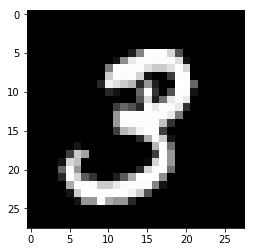

3


In [5]:
plt.imshow(mnist.train.images[1].reshape((28,28)), cmap='gray')
plt.show()
print(mnist.train.labels[1])

In [6]:
mnist.validation.images.shape

(5000, 784)

In [7]:
mnist.test.images.shape

(10000, 784)

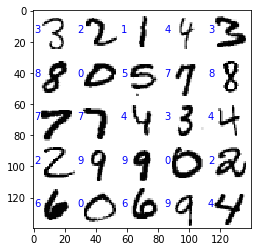

In [8]:
def show_images(imgs, labels, highlight=None):
    if highlight is None:
        highlight = np.zeros(len(labels)) > 0
    colors = np.array([(0,0,1), (1,0,0)])
    colors = colors[highlight.astype(int)]

    N=imgs.shape[0]
    w=int(np.ceil(np.sqrt(N)))
    h=int(N/w)
    imgs.shape=(N, 28,28)

    rows = [ np.hstack(imgs[i:i+w,:,:]) for i in range(0,w*h, w)]
    tiled = np.vstack(rows)
    plt.imshow(1.0 - tiled, cmap='gray')

    for i in range(w):
        for j in range(h):
            plt.text(i*28, 14+j*28, '%s'%labels[j*w+i], color=colors[j*w+i])
    plt.show()
#%pylab inline
#pylab.rcParams['figure.figsize'] = (10,10)  
idx = np.random.randint(0, 55000, 25)
show_images(mnist.train.images[idx], mnist.train.labels[idx])

# Define a graph to classify images

In [0]:
with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, [None, 784], name='x')  # x is BatchSize x 784
    y = tf.placeholder(tf.int32, [None], name='y')  # y is BatchSize x 1

Define some useful functions:

In [0]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
      mean = tf.reduce_mean(tf.cast(var, tf.float32))
      tf.summary.scalar('mean', mean)
      with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
      tf.summary.scalar('stddev', stddev)
      tf.summary.scalar('max', tf.reduce_max(var))
      tf.summary.scalar('min', tf.reduce_min(var))
      tf.summary.histogram('histogram', var)

In [0]:
from pprint import pprint
def affine_layer(input_tensor, output_dim, layer_name, act=tf.nn.relu):
    """
    Build one simple Affine layer: y = W*x + b
    Adds non-linearity and collects statistics
    """
    input_shape = input_tensor.get_shape().as_list()
    input_dim = input_shape[-1]

    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            shape = [input_dim, output_dim]
            init = tf.truncated_normal(shape, stddev=0.1)
            weights = tf.Variable(init)
            #variable_summaries(weights)
        with tf.name_scope('biases'):
            initial = tf.constant(0.1, shape=[output_dim])
            biases = tf.Variable(initial)
            #variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            #tf.summary.histogram('pre_activations', preactivate)
    activations = act(preactivate, name='activation')
    #tf.summary.histogram('activations', activations)
    print("Added Affine layer %d -> %d with %s" % (input_dim, output_dim, act.__name__))
    return activations

### Define our simple network

In [12]:
hidden = affine_layer(x, 500, 'hidden')
prediction = affine_layer(hidden, 10, 'pred', act=tf.identity)

Added Affine layer 784 -> 500 with relu
Added Affine layer 500 -> 10 with identity


In [0]:
sess = tf.InteractiveSession()

We built an "inference" function that receives a batch of images and returns a tensorflow object of the prediction. 

The next component is creating a loss function.

In [0]:
def create_loss(predict, labels):
    # The raw formulation of cross-entropy,
    #
    # tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(tf.softmax(y)),
    #                               reduction_indices=[1]))
    #
    # can be numerically unstable.
    #
    # So here we use tf.nn.softmax_cross_entropy_with_logits on the
    # raw outputs of the nn_layer above, and then average across
    # the batch.
    
    #labels_1hot = tf.one_hot(labels, depth=10)
    #diff = tf.reduce_mean(tf.square(labels_1hot - predict), reduction_indices=[1])
    
    diff = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, 
                                                   logits=predict)
    with tf.name_scope('total'):
        cross_entropy = tf.reduce_mean(diff)
    tf.summary.scalar('cross_entropy', cross_entropy)
    return cross_entropy
  

In [0]:
loss = create_loss(prediction, y)

In [0]:
BATCH_SIZE = 100
eta = 0.001

In [0]:
with tf.name_scope('train'):
    #train_step = tf.train.AdamOptimizer(eta).minimize(loss)
    train_step = tf.train.AdamOptimizer(eta).minimize(loss)

In [0]:
correct_prediction = tf.equal(y, tf.cast(tf.argmax(prediction, axis=1), tf.int32))
accuracy = 100.0 * tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
tf.summary.scalar('accuracy', accuracy)
merged = tf.summary.merge_all()

Merge all the summaries and start training:

In [0]:
log_dir = '/tmp/tensorboard-mnist/'
if tf.gfile.Exists(log_dir):  # Delete previous runs
    import shutil
    shutil.rmtree(log_dir)
tf.gfile.MakeDirs(log_dir)

train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
test_writer = tf.summary.FileWriter(log_dir + '/test')

tf.global_variables_initializer().run()

Accuracy at iteration    0:  17.41%  (train is   20.0%)
Accuracy at iteration   20:  84.52%  (train is  65.75%)
Accuracy at iteration   40:  88.72%  (train is  86.15%)
Accuracy at iteration   60:  89.71%  (train is   89.2%)
Accuracy at iteration   80:  91.14%  (train is   89.9%)
Accuracy at iteration  100:  92.22%  (train is   90.0%)
Accuracy at iteration  120:  92.17%  (train is   92.1%)
Accuracy at iteration  140:   93.1%  (train is  92.35%)
Accuracy at iteration  160:   93.6%  (train is   92.5%)
Accuracy at iteration  180:  93.27%  (train is  93.75%)
Accuracy at iteration  200:  94.01%  (train is   93.9%)
Accuracy at iteration  220:  93.92%  (train is   93.3%)
Accuracy at iteration  240:  93.99%  (train is  93.75%)
Accuracy at iteration  260:  93.86%  (train is  93.65%)
Accuracy at iteration  280:  94.72%  (train is  93.65%)
Accuracy at iteration  300:   94.4%  (train is   94.1%)
Accuracy at iteration  320:  94.41%  (train is   95.1%)
Accuracy at iteration  340:  94.62%  (train is  

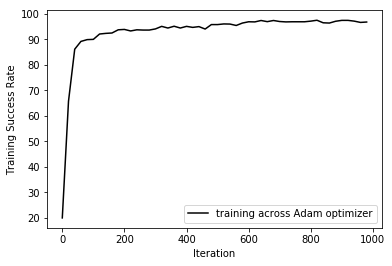

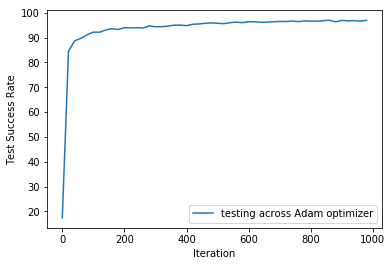

In [20]:

import matplotlib.pyplot as plt

acc_list = []
batch = BATCH_SIZE
i_lst = []
p_lst = []
b_lst = []
for i in range(1000):
    xs, ys = mnist.train.next_batch(batch)
    ys = ys.astype(np.int32)
    summary, acc, _ = sess.run([merged, accuracy, train_step], 
                               feed_dict={x:xs, y:ys})
    acc_list.append(acc)
    train_writer.add_summary(summary, i)
    if i % 20 == 0:   # Measure accuracy on the test set
        summary, test_acc = sess.run([merged, accuracy], 
                                     feed_dict={x:mnist.test.images, 
                                                y:mnist.test.labels})
        test_writer.add_summary(summary, i)
        print('Accuracy at iteration %4d: %6s%%  (train is %6s%%)' % (i, test_acc, np.mean(acc_list)))
        i_lst.append(i)
        p_lst.append(test_acc)
        b_lst.append(np.mean(acc_list))
        acc_list=[]
        

train_writer.flush()
test_writer.flush()    

plt.plot(i_lst, b_lst, color="black", label='training across Adam optimizer')   
plt.xlabel("Iteration")
plt.ylabel("Training Success Rate")
plt.legend()
plt.show()

plt.plot(i_lst, p_lst, label='testing across Adam optimizer')   
plt.xlabel("Iteration")
plt.ylabel("Test Success Rate")
plt.legend()
plt.show()



### (tensorBoard)

# Let's look at some predictions

In [0]:
xs, ys = mnist.test.next_batch(BATCH_SIZE)
ys = ys.astype(np.float32)

In [22]:
pred = sess.run(prediction, feed_dict={x:xs})
pred = np.argmax(pred, axis=1)
errors = pred != ys
print("Found %d/%d errors"%(np.sum(errors), len(errors)))


Found 2/100 errors


In [0]:
pred = sess.run(prediction, feed_dict={x:mnist.test.images})
pred = np.argmax(pred, axis=1)

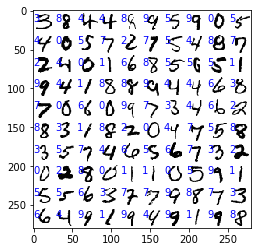

In [24]:
show_images(xs, pred)

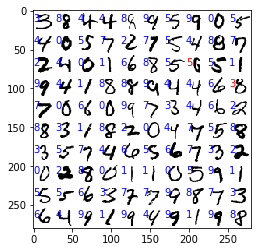

In [25]:
show_images(xs, pred, errors)

Error rate is 3.14%


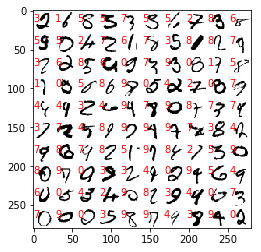

In [26]:
errors = pred != mnist.test.labels
print('Error rate is %.2f%%'%(100.0*sum(errors) / len(errors)))

pick = np.random.permutation(np.where(errors)[0])
pick = pick[:100]
show_images(mnist.test.images[pick], pred[pick], errors[pick])

So we have a simple, nearly linear, classifier